## Exploring data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import hydroeval as he
from tensorflow import keras
import hydroeval as he

In [2]:
df_b = pd.read_csv("basel.csv", index_col=0)
df_b.head()

,datetime,et,p,t,obs
0,1981-01-01,0.000405,0.003536,-0.250816,670.0
1,1981-01-02,0.000472,0.003379,2.172385,647.0
2,1981-01-03,0.000576,0.017352,5.165919,727.0
3,1981-01-04,0.000443,0.022734,1.019687,1363.0
4,1981-01-05,0.000364,0.005195,-2.055391,1202.0


In [3]:
df_b.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
et,7305.0,0.001714,0.001106,0.000174,0.000699,0.001463,0.002551,0.005657
p,7305.0,0.004003,0.006059,0.000000,0.000000,0.001118,0.005937,0.064737
t,7305.0,7.407180,7.137879,-21.928990,2.108310,7.466198,13.141790,25.095398
obs,7305.0,1089.771141,460.346002,393.000000,751.000000,1003.000000,1332.000000,4583.996000


In [4]:
q_basel = pd.read_csv("q_basel.csv")
q_basel = q_basel.drop(["obs"], axis =1)
q_basel = q_basel.set_index("datetime")
q_basel

,pcr,res
datetime,,
1981-01-01,605.06915,64.93085
1981-01-02,599.35767,47.64233
1981-01-03,874.38354,-147.38354
1981-01-04,998.86804,364.13196
1981-01-05,968.06270,233.93730
...,...,...
2000-12-27,1055.62610,-393.59110
2000-12-28,1027.90730,-371.65430
2000-12-29,860.76306,-208.61306


In [5]:
# making the time colum index of df
df_basel = df_b.set_index("datetime")
df_basel.shape

(7305, 4)

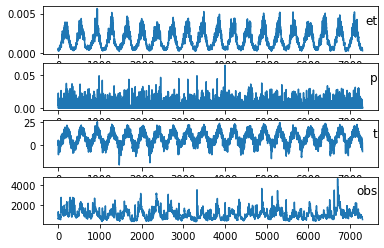

In [6]:
# visualising time series
from matplotlib import pyplot
values = df_basel.values

# specify columns to plot
groups =[0,1,2,3]
i=1
# plot each column
pyplot.figure()
for g in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, g])
    pyplot.title(df_basel.columns[g], y= 0.5, loc ="right")
    i += 1
pyplot.show()



## LSTM data prepration

In [7]:
# a function that, given the initial dataframe, return a shorter dataframe sequence of length.
# the shorter sequence is selected at random.

from numpy.random import seed
seed(1)
def subsample_sequence(df, length):

    last_possible = df.shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]

    return df_sample

In [8]:
# a function to deal with nan values
def fillna(X, df_mean):

    na = X.mean()

    na.fillna(df_mean)
    return na

# a function that given a full dataframe, first subsample this dataset into a shorter sequence,
# and then splits the shorter dataframe into a training sequence and a value to predict.

def split_subsample_sequence(df, length, df_mean=None):
    # Little trick to improve the time
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    if set(["pcr","res"]).issubset(df_subsample.columns):
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['pcr']
    else:
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['obs']

    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(df, length, df_mean)
        return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:df_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, df_mean))
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [9]:
# another function that generates an entire dataset of multiple subsamples,
# given an initial dataframe df, a number of desired sequences, and a length for each sequence

def get_X_y(df, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [10]:
# train test split
len_ = int(0.75 *df_basel.shape[0])

df_train = df_basel[:len_]
df_test = df_basel[len_:]

In [11]:
# time window based on  insight gained from ccf function in R is equal to 50
from numpy.random import seed
seed(1)
X_train, y_train = get_X_y(df_train, 2000, 51) # The training set correspond to 1000 sequences, each of size 50 (+ the time to predict)
X_test, y_test = get_X_y(df_test, 731, 51)


In [12]:
# dropping "obs" var from predictors in train set
X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
X_train_ready = np.asarray(X_train_new)
X_train_ready.shape

(2000, 50, 3)

In [13]:
# dropping "obs" var from predictors in test set
X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
X_test_ready = np.asarray(X_test_new)
X_test_ready.shape

(731, 50, 3)

## Normalizing data

In [14]:
# https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)


In [15]:
# normalize output
y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train_shaped)


y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))

y_test_scaled = scaler.transform(y_test_shaped)
y_test_scaled.shape

(731, 1)

## Hyperparameter Optimization

In [16]:
# START WITH FINETUNE NOTEBOOK ADD THE BASE MODEL DESCRIBED THERE MAYBE

# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
# https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb
# the ANN note book
# https://www.kaggle.com/code/rendyk/neural-network-hyperparameter-tuning/notebook
# https://keras.io/keras_tuner/

In [17]:
# define the baseline model
import keras_tuner as kt
from tensorflow import keras



def build_baseline_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train_scaled.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer=('adam'),metrics = ['mse']) # add learning rate and decay and maybe weight initialization
    return model


In [18]:
#instantiate the Hyperband tuner

tuner = kt.Hyperband(build_baseline_model,
                     overwrite=True,
                     objective='mse',
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations = 2,
                     directory='thesis',
                     project_name='LSTM_Basel_hyperparameter_tunning')

In [19]:
# create a callback to stop training early after reaching a certain value for the validation loss.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# run the tuner
tuner.search(X_train_scaled, y_train_scaled, epochs=25, validation_split=0.2, callbacks=[es])

#get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]


Trial 60 Complete [00h 17m 24s]
mse: 0.00622278219088912

Best mse So Far: 0.005958182271569967
Total elapsed time: 05h 40m 55s
INFO:tensorflow:Oracle triggered exit


In [25]:
# https://keras.io/api/keras_tuner/tuners/base_tuner/#getbesthyperparameters-method
model = tuner.hypermodel.build(best_hps)

In [23]:
tuner.get_best_models(num_models=1)

In [31]:
tuner.results_summary(num_trials=10)

Results summary
Results in thesis\LSTM_Basel_hyperparameter_tunning
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 480
n_layers: 2
lstm_0_units: 96
layer_2_neurons: 384
Dropout_rate: 0.1
dense_activation: tanh
lstm_1_units: 416
lstm_2_units: 64
lstm_3_units: 320
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005958182271569967
Trial summary
Hyperparameters:
input_unit: 448
n_layers: 2
lstm_0_units: 128
layer_2_neurons: 384
Dropout_rate: 0.0
dense_activation: tanh
lstm_1_units: 320
lstm_2_units: 128
lstm_3_units: 32
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0060155633836984634
Trial summary
Hyperparameters:
input_unit: 128
n_layers: 4
lstm_0_units: 160
layer_2_neurons: 256
Dropout_rate: 0.30000000000000004
dense_activation: tanh
lstm_1_units: 256
lstm_2_units: 448
lstm_3_units: 160
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.00622278219088912
Trial summary
Hyp